In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.metrics import accuracy_score

### Import Raw Data

In [2]:
app_event = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/app_events.csv")
app_label = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/app_labels.csv")
label_cat = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/label_categories.csv")
event = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/events.csv")
phone = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/phone_brand_device_model.csv")
gatrain = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/gender_age_train.csv")
gatest = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/gender_age_test.csv")

In [3]:
# Quick look at the data
print ('----------------------------------------------------')
print ('app_event:')
print (app_event.head())
print ('----------------------------------------------------')
print ('app_label:')
print (app_label.head())
print ('----------------------------------------------------')
print ('label_cat:')
print (label_cat.head())
print ('----------------------------------------------------')
print ('event:')
print (event.head())
print ('----------------------------------------------------')
print ('phone:')
print (phone.head())
print ('----------------------------------------------------')
print ('gatrain:')
print (gatrain.head())
print ('----------------------------------------------------')


----------------------------------------------------
app_event:
   event_id               app_id  is_installed  is_active
0         2  5927333115845830913             1          1
1         2 -5720078949152207372             1          0
2         2 -1633887856876571208             1          0
3         2  -653184325010919369             1          1
4         2  8693964245073640147             1          1
----------------------------------------------------
app_label:
                app_id  label_id
0  7324884708820027918       251
1 -4494216993218550286       251
2  6058196446775239644       406
3  6058196446775239644       407
4  8694625920731541625       406
----------------------------------------------------
label_cat:
   label_id           category
0         1                NaN
1         2     game-game type
2         3   game-Game themes
3         4     game-Art Style
4         5  game-Leisure time
----------------------------------------------------
event:
   event_id     

In [4]:
# Check if all phones in "phone brand" table is in "gender train table"
# The result show the table "gatrain" is the subset of phone list
phone_list = phone.device_id.unique()
phone_in_gatrain = gatrain.device_id.unique()
phone_in_event = event.device_id.unique()
print (set(phone_list) > set(phone_in_gatrain))

True


In [5]:
# Merge "gatrain" with "phone" to get phone brand, model and age groups in the same table
gatrain = gatrain.drop_duplicates()
phone = phone.drop_duplicates()
df = gatrain.merge(phone, on = ['device_id'])
print (len(gatrain))
print (len(df))

74645
74646


In [6]:
df.dtypes

device_id        int64
gender          object
age              int64
group           object
phone_brand     object
device_model    object
dtype: object

In [7]:
df.group.unique()

array(['M32-38', 'M29-31', 'F24-26', 'F33-42', 'F27-28', 'M39+', 'M23-26',
       'M27-28', 'M22-', 'F43+', 'F23-', 'F29-32'], dtype=object)

In [8]:
df['Brand_Model'] = df['phone_brand']+','+df['device_model']
#df['agegroup'] = df.group.str[1:]
df['Adult'] = np.where(df.age<=18,'Teen', 'Adult')
df['Age_30_Split'] = np.where(df.age<30,'Below 30', '30 and Above')
df['AgeGroup'] = df.age//10*10


In [9]:
df.head()

,device_id,gender,age,group,phone_brand,device_model,Brand_Model,Adult,Age_30_Split,AgeGroup
0,-8076087639492063270,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30
1,-2897161552818060146,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30
2,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30
3,-4938849341048082022,M,30,M29-31,小米,红米note,"小米,红米note",Adult,30 and Above,30
4,245133531816851882,M,30,M29-31,小米,MI 3,"小米,MI 3",Adult,30 and Above,30


### Plot User Age Distribution

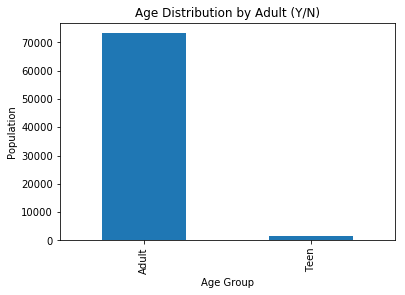

In [10]:
age_distr1 = df.groupby(['Adult']).device_id.nunique()
age_distr2 = df.groupby(['Age_30_Split']).device_id.nunique()
age_distr3 = df.groupby(['AgeGroup']).device_id.nunique()
ax1 = age_distr1.plot(kind = 'bar', title = 'Age Distribution by Adult (Y/N)')
# set labels for both axes
ax1.set(xlabel='Age Group', ylabel='Population')
plt.show()

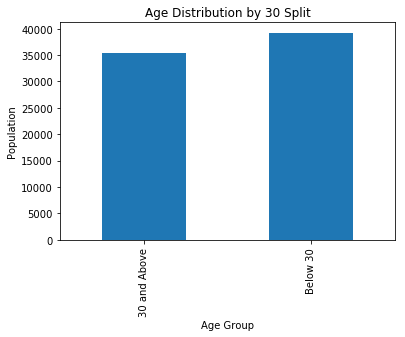

In [11]:
ax2 = age_distr2.plot(kind = 'bar', title = 'Age Distribution by 30 Split')
ax2.set(xlabel='Age Group', ylabel='Population')
plt.show()

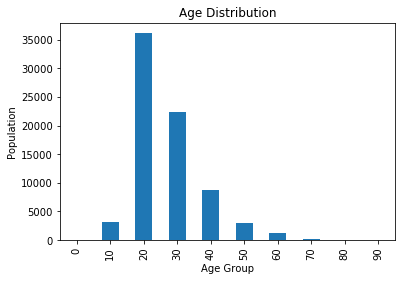

In [12]:
ax3 = age_distr3.plot(kind = 'bar', title = 'Age Distribution')
ax3.set(xlabel='Age Group', ylabel='Population')
plt.show()

### Age vs. Phone Brand
* One brand stands out between "above 30" & "below 30" groups - Meizu!
* Younger generations tend to use Meizu brand which is a cheaper version of IPhone or Samsung

In [13]:
# Phone Brand Model Distribution
df.Brand_Model.value_counts()
counts = df.Brand_Model.value_counts()
percent = df.Brand_Model.value_counts(normalize=True) \
           .mul(100).round(1).astype(str) + '%'
cum_pnct = (counts.cumsum()/counts.sum())\
           .mul(100).round(1).astype(str) + '%'
BrandModel = pd.DataFrame({'counts': counts, 'per': percent, 'cum_pnt':cum_pnct })
BrandModel.head(50)

,counts,cum_pnt,per
"小米,红米note",3013,4.0%,4.0%
"小米,MI 3",2299,7.1%,3.1%
"小米,MI 2S",2136,10.0%,2.9%
"三星,Galaxy Note 3",2065,12.7%,2.8%
"小米,MI 4",1910,15.3%,2.6%
"三星,Galaxy Note 2",1610,17.5%,2.2%
"三星,Galaxy S4",1568,19.6%,2.1%
"华为,荣耀6",1239,21.2%,1.7%
"华为,荣耀畅玩4X",1102,22.7%,1.5%
"华为,荣耀3C",1067,24.1%,1.4%


In [14]:
# Phone Brand Distribution
df.phone_brand.value_counts()
counts = df.phone_brand.value_counts()
percent = df.phone_brand.value_counts(normalize=True) \
           .mul(100).round(1).astype(str) + '%'
cum_pnct = (counts.cumsum()/counts.sum())\
           .mul(100).round(1).astype(str) + '%'
Brand = pd.DataFrame({'counts': counts, 'per': percent, 'cum_pnt':cum_pnct })
Brand_top20 = Brand.head(20)
Brand_top20

,counts,cum_pnt,per
小米,17300,23.2%,23.2%
三星,13669,41.5%,18.3%
华为,12960,58.8%,17.4%
OPPO,5783,66.6%,7.7%
vivo,5637,74.1%,7.6%
魅族,4699,80.4%,6.3%
酷派,3339,84.9%,4.5%
联想,2691,88.5%,3.6%
金立,1123,90.0%,1.5%
HTC,1013,91.4%,1.4%


In [15]:
# Get subset of data where users using top 20 phone brand
# valuelist =Brand_top20.iloc[:,0]
valuelist = Brand_top20.index.values.tolist()
df_subset = df[df.phone_brand.isin(valuelist)]
#a = df_subset.unstack('phone_brand')
#a

In [16]:
# Assign number to top 20 phone brand;
brandencoder = LabelEncoder().fit(df_subset.phone_brand)
df_subset['brand_encode'] = brandencoder.transform(df_subset['phone_brand'])

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
brand_by_agegroup = df_subset.groupby(['AgeGroup', 'phone_brand']).device_id.nunique()#.unstack(1)
brand_by_agegroup_df = pd.DataFrame(brand_by_agegroup)#.fillna(method='ffill')

In [18]:
# Keep Top 5 Phone Brands by 30 split flag
top5_brand = brand_by_agegroup.groupby(level=0).nlargest(5)
top5_brand

AgeGroup  AgeGroup  phone_brand
0         0         魅族                4
                    三星                1
10        10        小米              728
                    华为              388
                    OPPO            376
                    vivo            362
                    三星              288
20        20        小米             8795
                    三星             5784
                    华为             5404
                    vivo           3340
                    OPPO           3202
30        30        小米             5025
                    三星             4726
                    华为             4406
                    OPPO           1462
                    vivo           1287
40        40        华为             1892
                    三星             1891
                    小米             1767
                    OPPO            521
                    酷派              465
50        50        小米              652
                    三星              645
        

In [19]:
brand_by_agegroup2 = df_subset.groupby(['Age_30_Split', 'phone_brand']).device_id.nunique()#.unstack(1)
brand_by_agegroup_df2 = pd.DataFrame(brand_by_agegroup2)

In [20]:
# Keep Top 5 Phone Brands by 30 split flag
top5_brand = brand_by_agegroup2.groupby(level=0).nlargest(10)
top5_brand

Age_30_Split  Age_30_Split  phone_brand
30 and Above  30 and Above  小米             7777
                            三星             7596
                            华为             7168
                            OPPO           2205
                            vivo           1935
                            酷派             1695
                            魅族             1448
                            联想             1397
                            金立              528
                            HTC             485
Below 30      Below 30      小米             9523
                            三星             6073
                            华为             5792
                            vivo           3702
                            OPPO           3578
                            魅族             3251
                            酷派             1644
                            联想             1294
                            金立              595
                            HTC             528


In [21]:
model_by_agegroup = df_subset.groupby(['Age_30_Split', 'Brand_Model']).device_id.nunique()#.unstack(1)
model_by_agegroup_df = pd.DataFrame(model_by_agegroup)#.fillna(method='ffill')

In [22]:
# Keep Top 5 Phone Brands by 30 split flag
top5_model = model_by_agegroup.groupby(level=0).nlargest(20)
top5_model

Age_30_Split  Age_30_Split  Brand_Model     
30 and Above  30 and Above  小米,红米note           1552
                            三星,Galaxy Note 3    1165
                            三星,Galaxy Note 2     977
                            小米,MI 3              932
                            三星,Galaxy S4         799
                            小米,MI 4              789
                            小米,MI 2S             782
                            华为,Mate 7            658
                            华为,荣耀畅玩4X            651
                            华为,荣耀6               624
                            三星,Galaxy S3         520
                            小米,红米                490
                            小米,红米1S              489
                            华为,荣耀3C              473
                            三星,Galaxy S5         398
                            小米,红米2               398
                            华为,荣耀6 Plus          385
                            小米,红米Note2           380
 

In [23]:
model_by_agegroup2=df_subset.groupby(['Age_30_Split', 'device_model']).device_id.nunique()
top5_model = model_by_agegroup2.groupby(level=0).nlargest(10).unstack(1)
top5_model

Age_30_Split                30 and Above  Below 30
Age_30_Split device_model                         
30 and Above Galaxy Note 2         977.0       NaN
             Galaxy Note 3        1165.0       NaN
             Galaxy S4             799.0       NaN
             MI 2S                 782.0       NaN
             MI 3                  932.0       NaN
             MI 4                  789.0       NaN
             Mate 7                658.0       NaN
             红米note               1552.0       NaN
             荣耀6                   624.0       NaN
             荣耀畅玩4X                651.0       NaN
Below 30     Galaxy Note 2           NaN     633.0
             Galaxy Note 3           NaN     900.0
             Galaxy S4               NaN     769.0
             MI 2S                   NaN    1354.0
             MI 3                    NaN    1367.0
             MI 4                    NaN    1121.0
             红米note                  NaN    1461.0
             荣耀3C                    NaN     594.0
             荣耀6                     NaN     615.0
             魅蓝NOTE                  NaN     547.0

### Age vs. App Category
* It appears that app categories such as "wealth management" & "P2P net loan" are tend to be used by above 30 groups
* App categories such as "onlinemalls" & "Liquid medium" are tend to be use by younger crowd (below 30)

In [24]:
device_list = df['device_id'].tolist()
df_eventsubset = event[event.device_id.isin(device_list)]
df_events = df_eventsubset.merge(app_event, on = ['event_id'])
#df_events = df_events[df_events.is_active == 1]

In [25]:
df_events_new = df_events.loc[:,('device_id', 'app_id')].drop_duplicates()
app_label = app_label.drop_duplicates()
label_cat = label_cat.drop_duplicates()

In [26]:
device_app = df_events_new.merge(app_label, on = ['app_id']).merge(label_cat, on = ['label_id'])
df2 = df.merge(device_app, on = ['device_id'])
len(df2)

5753988

In [27]:
df3 = df2[(df2.category != 'Industry tag') & (df2.category != 'Property Industry 1.0') & (df2.category != 'Property Industry 2.0')
         & (df2.category != 'unknown') & (df2.category != 'Relatives 1') & (df2.category != 'Services 1') & (df2.category != '1 free')
         & (df2.category != 'Custom label') & (df2.category != 'And the Church') & (df2.category != 'IM')]
a = df3.groupby(['AgeGroup', 'category']).device_id.nunique()
top5_app = a.groupby(level=0).nlargest(5)
top5_app

AgeGroup  AgeGroup  category                
10        10        Personal Effectiveness 1     671
                    video                        671
                    music                        669
                    Cozy 1                       659
                    Finance                      653
20        20        Finance                     9898
                    Internet banking            9704
                    Personal Effectiveness 1    9698
                    Low risk                    9465
                    video                       9396
30        30        Finance                     7048
                    Internet banking            6976
                    Personal Effectiveness 1    6870
                    Low risk                    6775
                    Pay                         6592
40        40        Finance                     2970
                    Internet banking            2926
                    Personal Effectiveness 1    2845
 

In [28]:
df3 = df2[(df2.category != 'Industry tag') & (df2.category != 'Property Industry 1.0') & (df2.category != 'Property Industry 2.0')
         & (df2.category != 'unknown') & (df2.category != 'Relatives 1') & (df2.category != 'Services 1') & (df2.category != '1 free')
         & (df2.category != 'Custom label') & (df2.category != 'And the Church') & (df2.category != 'IM')]
b = df3.groupby(['Age_30_Split', 'category']).device_id.nunique()
top10_app2 = b.groupby(level=0).nlargest(10)
top10_app2

Age_30_Split  Age_30_Split  category                
30 and Above  30 and Above  Finance                     11355
                            Internet banking            11218
                            Personal Effectiveness 1    11019
                            Low risk                    10798
                            Pay                         10514
                            Moderate profitability      10142
                            High Flow                   10089
                            video                       10072
                            Third party payment         10052
                            Liquid medium               10003
Below 30      Below 30      Finance                     10551
                            Personal Effectiveness 1    10369
                            Internet banking            10340
                            Low risk                    10079
                            video                       10067
                 

In [37]:
# Focus on top 10 apps 
df4 = df3[(df3.category == 'Personal Effectiveness 1')|(df3.category == 'Wealth Management')|(df3.category == 'P2P net loan')
          |(df3.category == 'P2P net loan')|(df3.category == 'online malls')|(df3.category == 'Liquid medium')]
df_agg = pd.DataFrame({'device_count' : df4.groupby( [ "AgeGroup", "category"] ).device_id.nunique()}).reset_index()
df_agg.head()

,AgeGroup,category,device_count
0,10,Liquid medium,400
1,10,P2P net loan,306
2,10,Personal Effectiveness 1,671
3,10,Wealth Management,353
4,10,online malls,622


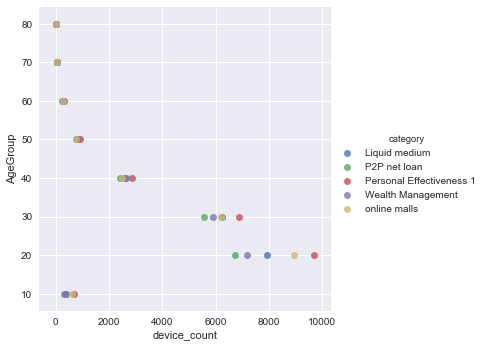

In [38]:
import seaborn as sns
sns.lmplot('device_count', 'AgeGroup', data=df_agg, hue='category', fit_reg=False)
plt.show()

### Age vs. Activity Time During the Day
* People above 30 tend to get up earlier than below 30 group... more activities before 8 for former group

In [39]:
event_new = event.merge(gatrain, on = ['device_id'])

In [41]:
# re-format timestamp column to datetime format in order to get other time attributes later
event_new.timestamp = event_new.timestamp.apply(pd.to_datetime)
event_new['hour'] = event_new['timestamp'].dt.hour
event_new['day'] = event_new['timestamp'].dt.day
event_new['dayofweek'] = event_new['timestamp'].dt.dayofweek+1
event_new['Adult'] = np.where(event_new.age<=18,'Teen', 'Adult')
event_new['Age_30_Split'] = np.where(event_new.age<30,'Below 30', '30 and Above')
event_new['AgeGroup'] = event_new.age//10*10
event_new.head()

,event_id,device_id,timestamp,longitude,latitude,gender,age,group,hour,day,dayofweek,Adult,Age_30_Split,AgeGroup
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,M,46,M39+,0,1,7,Adult,30 and Above,40
1,7104,29182687948017175,2016-05-02 09:37:02,121.38,31.24,M,46,M39+,9,2,1,Adult,30 and Above,40
2,29661,29182687948017175,2016-05-04 00:56:04,121.39,31.23,M,46,M39+,0,4,3,Adult,30 and Above,40
3,33133,29182687948017175,2016-05-06 05:01:15,121.38,31.24,M,46,M39+,5,6,5,Adult,30 and Above,40
4,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,M,46,M39+,9,6,5,Adult,30 and Above,40


In [42]:
# group by age and hour
en = event_new.groupby(['AgeGroup', 'hour']).device_id.nunique()
top_hours = en.groupby(level=0).nlargest(5)
top_hours

AgeGroup  AgeGroup  hour
10        10        18       251
                    12       250
                    22       244
                    21       239
                    13       238
20        20        10      4314
                    12      4290
                    11      4275
                    21      4242
                    20      4193
30        30        21      3438
                    10      3434
                    9       3336
                    20      3329
                    12      3316
40        40        10      1515
                    21      1510
                    9       1493
                    20      1492
                    19      1466
50        50        8        474
                    10       470
                    11       467
                    21       464
                    9        463
60        60        11       159
                    12       157
                    9        144
                    15       144
                  

In [43]:
en = event_new.groupby(['Age_30_Split', 'hour']).device_id.nunique()
top_hours = en.groupby(level=0).nlargest(20)
top_hours

Age_30_Split  Age_30_Split  hour
30 and Above  30 and Above  10      5598
                            21      5596
                            9       5475
                            20      5450
                            11      5423
                            12      5378
                            19      5377
                            8       5336
                            18      5208
                            17      5205
                            13      5145
                            22      5135
                            14      5077
                            7       5071
                            15      5067
                            16      5060
                            23      4311
                            6       4251
                            0       3556
                            5       2710
Below 30      Below 30      12      4540
                            10      4538
                            11      4511
                        

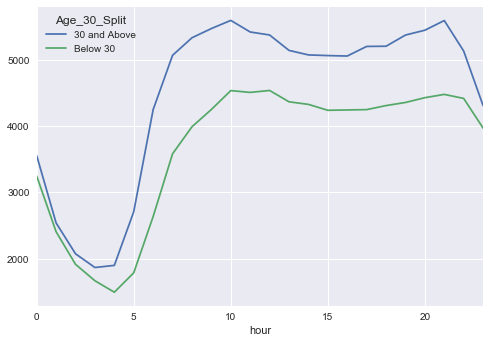

In [44]:
event_new.groupby(['Age_30_Split', 'hour']).device_id.nunique().unstack(0).plot()
#model_by_agegroup_df = pd.DataFrame(brand_by_agegroup)#.fillna(method='ffill')

### Logistic Regression Predict Age-30-Split Based on Phone Brand and App Category

In [45]:
df2.head()

,device_id,gender,age,group,phone_brand,device_model,Brand_Model,Adult,Age_30_Split,AgeGroup,app_id,label_id,category
0,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,1665047061121005617,549,Property Industry 1.0
1,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,-2145434552412465677,549,Property Industry 1.0
2,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,-3425831168385824047,549,Property Industry 1.0
3,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,-4822828198118893639,549,Property Industry 1.0
4,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,-4547357956657275284,549,Property Industry 1.0


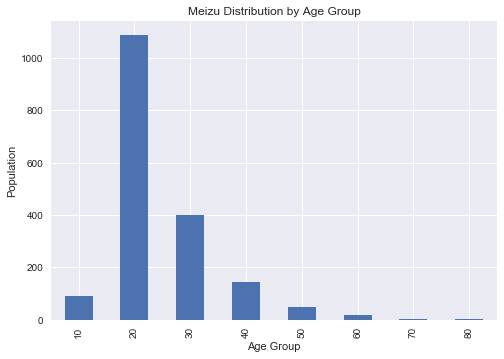

In [46]:
# Select Features and Show Distribution of Each Feature
# Feature 1 - Meizu Brand
df_model_base_data = df2
Meizu = df_model_base_data[df_model_base_data.phone_brand == '魅族']
Meizu_Dis = Meizu.groupby('AgeGroup').device_id.nunique().plot(kind='bar',title = 'Meizu Distribution by Age Group')
Meizu_Dis.set(xlabel='Age Group', ylabel='Population')
plt.show()

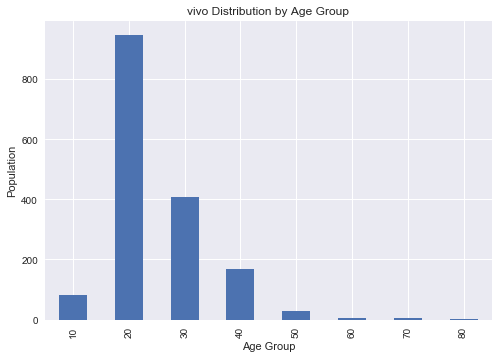

In [47]:
# Feature 2 - vivo Brand
vivo = df_model_base_data[df_model_base_data.phone_brand == 'vivo']
vivo_Dis = vivo.groupby('AgeGroup').device_id.nunique().plot(kind='bar',title = 'vivo Distribution by Age Group')
vivo_Dis.set(xlabel='Age Group', ylabel='Population')
plt.show()

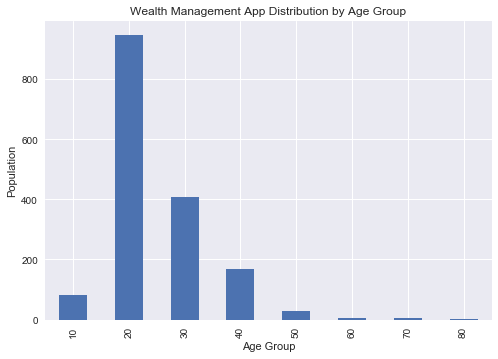

In [48]:
# Feature 3 - Wealth Management App
WealthMgmt = df_model_base_data[df_model_base_data.category == 'Wealth Management']
WealthMgmt_Dis = vivo.groupby('AgeGroup').device_id.nunique().plot(kind='bar',title = 'Wealth Management App Distribution by Age Group')
WealthMgmt_Dis.set(xlabel='Age Group', ylabel='Population')
plt.show()

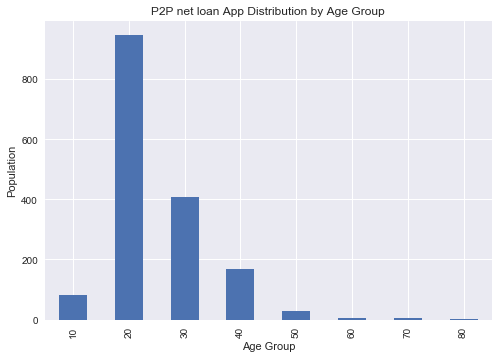

In [49]:
# Feature 4 - P2P net loan App
P2PNetLoan = df_model_base_data[df_model_base_data.category == 'P2P net loan']
P2PNetLoan_Dis = vivo.groupby('AgeGroup').device_id.nunique().plot(kind='bar',title = 'P2P net loan App Distribution by Age Group')
P2PNetLoan_Dis.set(xlabel='Age Group', ylabel='Population')
plt.show()

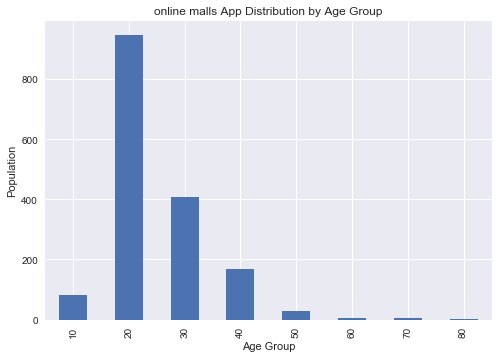

In [50]:
OnlineMall = df_model_base_data[df_model_base_data.category == 'online malls']
OnlineMall_Dis = vivo.groupby('AgeGroup').device_id.nunique().plot(kind='bar',title = 'online malls App Distribution by Age Group')
OnlineMall_Dis.set(xlabel='Age Group', ylabel='Population')
plt.show()

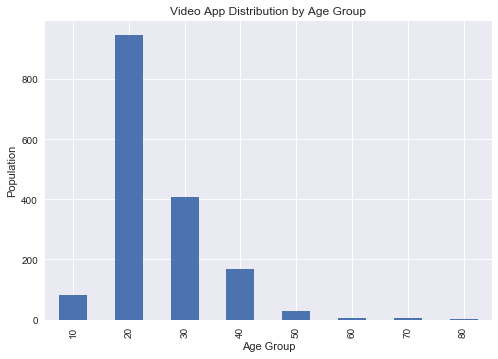

In [51]:
Video = df_model_base_data[df_model_base_data.category == 'video']
Video_Dis = vivo.groupby('AgeGroup').device_id.nunique().plot(kind='bar',title = 'Video App Distribution by Age Group')
Video_Dis.set(xlabel='Age Group', ylabel='Population')
plt.show()

In [53]:
# Create dummy variables for each feature
df_model_base_data['Meizu_Brand'] = np.where(df_model_base_data.phone_brand=='魅族',1, 0)
df_model_base_data['vivo_Brand'] = np.where(df_model_base_data.phone_brand=='vivo',1, 0)
df_model_base_data['Wealth_Management'] = np.where(df_model_base_data.category =='Wealth Management',1, 0)
df_model_base_data['P2PLoan'] = np.where(df_model_base_data.category =='P2P net loan',1, 0)
df_model_base_data['OnlineShopping'] = np.where(df_model_base_data.category =='online malls',1, 0)
df_model_base_data['Liquid_medium'] = np.where(df_model_base_data.category =='Liquid medium',1, 0)
df_model_base_data['Age_30_Cutoff'] = np.where(df_model_base_data.age<30, 1, 0)

In [54]:
df_model_base_data.head()

,device_id,gender,age,group,phone_brand,device_model,Brand_Model,Adult,Age_30_Split,AgeGroup,...,label_id,category,Meizu_Brand,vivo_Brand,Wealth_Management,P2PLoan,OnlineShopping,Video,Age_30_Cutoff,Liquid_medium
0,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,...,549,Property Industry 1.0,0,0,0,0,0,0,0,0
1,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,...,549,Property Industry 1.0,0,0,0,0,0,0,0,0
2,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,...,549,Property Industry 1.0,0,0,0,0,0,0,0,0
3,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,...,549,Property Industry 1.0,0,0,0,0,0,0,0,0
4,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",Adult,30 and Above,30,...,549,Property Industry 1.0,0,0,0,0,0,0,0,0


In [55]:
# Keep all useful columns
df_model_base_data_New = df_model_base_data[['Age_30_Cutoff', 'Meizu_Brand', 'vivo_Brand', 'Wealth_Management', 'P2PLoan',
                                            'OnlineShopping', 'Liquid_medium']]
# manually add the intercept
df_model_base_data_New['intercept'] = 1

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
df_model_base_data_New.head()

,Age_30_Cutoff,Meizu_Brand,vivo_Brand,Wealth_Management,P2PLoan,OnlineShopping,Liquid_medium,intercept
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1


In [57]:
train_cols = df_model_base_data_New.iloc[:,1:7]

In [58]:
train_cols.head()

,Meizu_Brand,vivo_Brand,Wealth_Management,P2PLoan,OnlineShopping,Liquid_medium
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [59]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    train_cols, df_model_base_data_New.Age_30_Cutoff, test_size=0.25, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(4315491, 6)
(1438497, 6)
(4315491,)
(1438497,)


In [60]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_train, Y_train)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(X_test), Y_test))

0.587163546396


### Tuning the Model

In [61]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [62]:
clf = LogisticRegression()
X_train_array = DataFrame.as_matrix(X_train)
Y_train_array = DataFrame.as_matrix(Y_train)
score = cv_score(clf, X_train_array, Y_train_array)
print(score)

0.587433504212


In [63]:
#Find the best C
#the grid of parameters to search over
Cs = [0.001,0.05,0.01, 0.1,1, 10, 100]

max_score = 0

for C in Cs:
        clf = LogisticRegression(C=C)
        score = cv_score(clf, X_train_array, Y_train_array)

        if score > max_score:
            max_score = score
            best_C =C
print (max_score, best_C)

0.587440919345 0.001


In [64]:
from sklearn.grid_search import GridSearchCV
clfl2=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(X_train_array, Y_train_array)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

C:\Users\Felix\Python\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Felix\Python\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(LogisticRegression(C=0.0001, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 {'C': 0.0001},
 0.5874578350412503,
 [mean: 0.58746, std: 0.00030, params: {'C': 0.0001},
  mean: 0.58744, std: 0.00027, params: {'C': 0.001},
  mean: 0.58743, std: 0.00028, params: {'C': 0.1},
  mean: 0.58743, std: 0.00029, params: {'C': 1},
  mean: 0.58743, std: 0.00029, params: {'C': 10},
  mean: 0.58743, std: 0.00029, params: {'C': 100}])

In [65]:
clfl2=LogisticRegression(C=fitmodel.best_params_['C'])
clfl2.fit(X_train_array, Y_train_array)
ypred2=clfl2.predict(X_test)
accuracy_score(ypred2, Y_test)

0.5871781449665866